In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d, barycentric_interpolate
from scipy.integrate import quad
import scipy.constants as sc 
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd

from PIL import Image

import Window_Function
import HERA_hack_FG
import pspec
import cross_pspec
import make_universe
import CII_foregrounds
from CCAT_p import CCAT_p

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=24
plt.rcParams['xtick.labelsize']=24

%load_ext autoreload
%autoreload 2

# No Foregrounds, HERA 128 autocorrelation  

In [2]:
################## TELESCOPE STUFF ##################
# dishes = np.array([[0,0],[-57.39295490174667,-57.39295490174667]])#,[30,30]]),[0,60],[2,55]])#,[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_128.dat')
hera_bls = data[:,:-1]

npix_row,npix_col = 40,40 

#dishes = np.array([[0,0],[33.33,0],[0,70.71],[33.33, 70.71]])
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack_FG.telescope(hera_bls, latitude=-30, channel_width=0.1, Tsys=300, beam_width=2, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 1, freq = 150, delta_t = 0.01 ,corners = acorner, beam_sigma_cutoff=2.5, sky_shape = (npix_row,npix_col), norm = True, pbeam = False)

obs.compute_M(None,None)

## Make universe

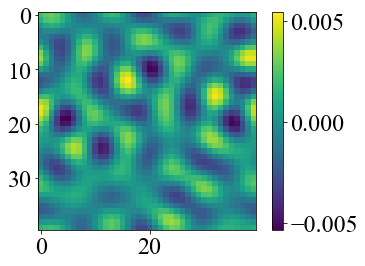

In [3]:
#restrict power spectrum only to the observable modes!
def ps(x):
    mu, sigma = 0.03,0.001
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))

################### MAKE UNIVERSE STUFF ################
Ly = 1000
Lx = 1000

make_uni = make_universe.universe(ps,npix_row,npix_col,Ly,Lx, mean = 0) #100 Mpc by 100Mpc

universe = make_uni.make_2D_universe()

stacked_sky = np.hstack(universe.T)

plt.imshow(universe)
plt.colorbar()

def pixelate(img, npixes):
    n, m = img.shape
    window_n = n/npixes[0]
    n, m = n - n % window, m - m % window
    print(n % window)
    print(n % window)
    img1 = np.zeros((np.int(n/window), np.int(m/window)))
    for x in range(0, np.int(n/window)):
        for y in range(0, np.int(m/window)):
            img1[x,y] = img[window*x:(window*x)+window,y*window:(y*window)+window].mean(axis=(0,1)) 
    return img1

pixelated_universe = pixelate(universe, 5) #make new pixel 2x old pixel 

print(pixelated_universe.shape)
plt.imshow(pixelated_universe)

def pixelate(img, window):
    n, m= img.shape
    n, m = n - n % window, m - m % window
    print(n % window)
    print(n % window)
    img1 = np.zeros((n, m))
    for x in range(0, n, window):
        for y in range(0, m, window):
            img1[x:x+window,y:y+window] = img[x:x+window,y:y+window].mean(axis=(0,1))
        
    return img1

pixelated_universe = pixelate(universe, 4) #make new pixel 2x old pixel 

print(pixelated_universe.shape)
plt.imshow(pixelated_universe)

(0.0, 0.04)

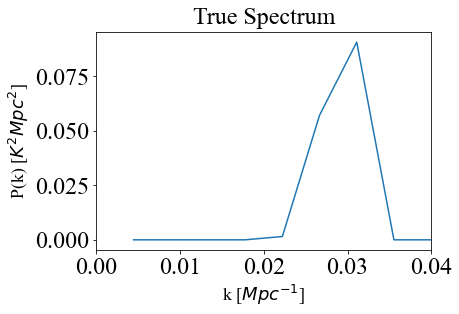

In [4]:
power_spec_universe = pspec.Power_Spectrum(universe,1000 ,1000,nbins = 40,log = False) 
pk_universe = power_spec_universe.compute_2D_pspec()

plt.plot(pk_universe[0],pk_universe[1])
plt.title('True Spectrum', y = 1.01, fontsize = 24)
plt.xlabel('k [$Mpc^{-1}$]', fontsize = 18)
plt.ylabel('P(k) [$K^2 Mpc^{2}$]', fontsize = 18)
plt.xlim(0,0.04)

In [5]:
#Determining the scales Hera is sensitive to

baselines = np.sqrt(HERA.bls[:,0]**2 +HERA.bls[:,1]**2)

print(min(baselines),'m,', max(baselines),'m')

largest_angle = 2/min(baselines)
smallest_angle = 2/max(baselines)

largest_scale = largest_angle*cosmo.comoving_distance(8.524).value
smallest_scale = smallest_angle*cosmo.comoving_distance(8.524).value

k_smallest = (2*np.pi)/smallest_scale
k_largest = (2*np.pi)/largest_scale

print(k_largest,'Mpc^-1,',k_smallest,'Mpc^-1')


14.599999999999989 m, 183.71263792492158 m
0.004919374255567188 Mpc^-1, 0.06190076859110932 Mpc^-1


## Make the observation n times and compute average spec

In [23]:
#Make the observation
hera_obs = np.real(obs.convolve_map(stacked_sky,None,None))
hera_obs_box = np.reshape(hera_obs,(40,40)).T

######### POWER SPECTRUM STUFF ###########

Lx_hera = cosmo.comoving_distance(8.5).value*obs.delta_phi*obs.sky_shape[0]
Ly_hera = cosmo.comoving_distance(8.5).value*obs.delta_theta * obs.sky_shape[1]

power_spec = pspec.Power_Spectrum(hera_obs_box,Ly_hera ,Lx_hera,40,False) #100 Mpc by 100Mpc --> have to scale fft I think 
pk_hera = power_spec.compute_2D_pspec()



nreal = 120

sum_spec_obs = np.zeros(39)


Lx_hera = cosmo.comoving_distance(8.5).value*obs.delta_phi*obs.sky_shape[0]
Ly_hera = cosmo.comoving_distance(8.5).value*obs.delta_theta*obs.sky_shape[1]



# for i in range(nreal):
#     #make fake universe
# #     universe = make_uni.make_2D_universe()
    
#     #observe the fake universe
#     stacked_sky = np.hstack(universe.T)
#     sky = np.real(obs.convolve_map(stacked_sky,None,None))
#     square_sky = np.reshape(sky,(npix_row,npix_col)).T
    
#     #calculate output spec
#     power_spec_telescope = pspec.Power_Spectrum(square_sky,Ly_hera ,Lx_hera,nbins = 40,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
#     pk_telescope = power_spec_telescope.compute_2D_pspec()
#     sum_spec_obs += pk_telescope[1] #average

# averaged_obs = sum_spec_obs/nreal




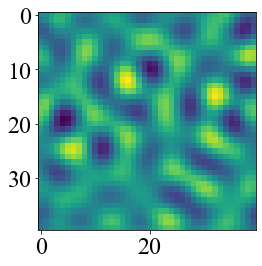

In [24]:
plt.imshow(hera_obs_box)

(0.0, 0.04)

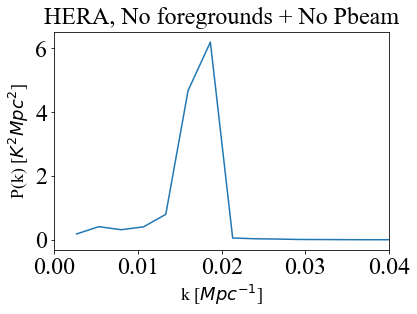

In [7]:
# #Make the observation
# hera_obs = np.real(obs.convolve_map(stacked_sky,None,None))
# hera_obs_box = np.reshape(hera_obs,(30,30)).T

# ######### POWER SPECTRUM STUFF ###########

# Lx_hera = cosmo.comoving_distance(8.5).value*obs.delta_phi*obs.sky_shape[0]
# Ly_hera = cosmo.comoving_distance(8.5).value*obs.delta_theta * obs.sky_shape[1]

# power_spec = pspec.Power_Spectrum(hera_obs_box,Ly_hera ,Lx_hera,40,False) #100 Mpc by 100Mpc --> have to scale fft I think 
pk_hera = power_spec.compute_2D_pspec()

plt.plot(pk_hera[0],pk_hera[1])
plt.title('HERA, No foregrounds + No Pbeam', y = 1.01, fontsize = 24)
plt.xlabel('k [$Mpc^{-1}$]', fontsize = 18)
plt.ylabel('P(k) [$K^2 Mpc^{2}$]', fontsize = 18)

plt.xlim(0,0.04)

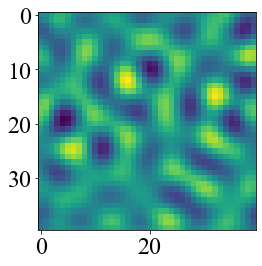

In [8]:
plt.imshow(hera_obs_box)

# No Foregrounds, CCAT-p Auto spectrum

In [46]:
RA = np.linspace(1,1.0015,npix_col)
DEC = np.linspace(1,1.0015,npix_row)


noisy_convolve = CCAT_p(universe,RA,DEC,274,6,False, 2.5e6, 3*(60*60), 0.75) 

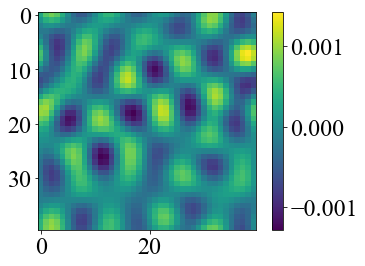

In [47]:
plt.imshow(noisy_convolve)
plt.colorbar()#noise before or after the blur?? before cuz Tsys 

In [30]:
cross_spec = cross_pspec.Cross_Spectrum(noisy_convolve, hera_obs_box, Ly_hera ,Lx_hera,nbins = 40,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
pk_cross = cross_spec.compute_2D_pspec()


(0.0, 0.04)

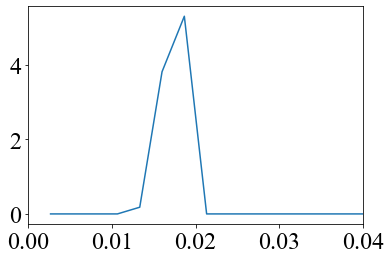

In [33]:
plt.plot(pk_cross[0],pk_cross[1])
plt.xlim(0,0.04)

In [11]:
power_spec_ccat = pspec.Power_Spectrum(noisy_convolve,Ly_hera ,Lx_hera,nbins = 40,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
pk_ccat = power_spec_ccat.compute_2D_pspec()

(0.0, 0.05)

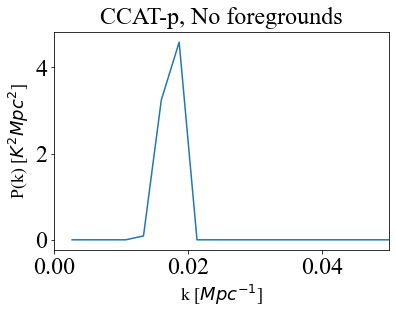

In [12]:
plt.plot(pk_ccat[0],pk_ccat[1])
plt.title('CCAT-p, No foregrounds', y = 1.01, fontsize = 24)
plt.xlabel('k [$Mpc^{-1}$]', fontsize = 18)
plt.ylabel('P(k) [$K^2 Mpc^{2}$]', fontsize = 18)
plt.xlim(0,0.05)

In [13]:
#Make the observation

sum_spec_obs_ccat = np.zeros(39)


Lx_hera = cosmo.comoving_distance(8.5).value*obs.delta_phi*obs.sky_shape[0]
Ly_hera = cosmo.comoving_distance(8.5).value*obs.delta_theta*obs.sky_shape[1]



for i in range(nreal):
    #make fake universe
#     universe = make_uni.make_2D_universe()
    
    #observe the fake universe
    noisy_convolve = CCAT_p(universe,RA,DEC,274,0.003,True, 2.5e6, 3*(60*60), 0.75)
    
    #calculate output spec
    power_spec_ccat = pspec.Power_Spectrum(noisy_convolve,Ly_hera ,Lx_hera,nbins = 40,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
    pk_ccat = power_spec_telescope.compute_2D_pspec()
    
    
    sum_spec_obs_ccat += pk_ccat[1] #average


averaged_obs_ccat = sum_spec_obs_ccat/nreal

(0.0, 0.04)

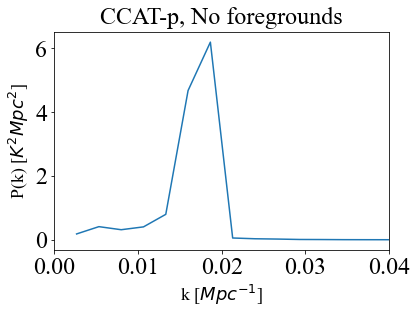

In [14]:
plt.plot(pk_ccat[0],averaged_obs_ccat)
plt.title('CCAT-p, No foregrounds', y = 1.01, fontsize = 24)
plt.xlabel('k [$Mpc^{-1}$]', fontsize = 18)
plt.ylabel('P(k) [$K^2 Mpc^{2}$]', fontsize = 18)
plt.xlim(0,0.04)

# Cross Spectrum 

In [80]:
sum_spec_obs_cross = np.zeros(39)

nreals = 50
nbins = 40

Lx_hera = cosmo.comoving_distance(8.5).value*obs.delta_phi*obs.sky_shape[0]
Ly_hera = cosmo.comoving_distance(8.5).value*obs.delta_theta*obs.sky_shape[1]
# plot each realization separately 

pk_reals = np.zeros((nreals, nbins-1))
k_cross = []

for i in range(nreals):
#     make fake universe
    universe = make_uni.make_2D_universe()
    
    #observe the fake universe
    noisy_convolve = CCAT_p(universe,RA,DEC,274,6,True, 2.5e6, 3*(60*60), 0.75)
    
    #observe the fake universe
    stacked_sky = np.hstack(universe.T)
    sky = np.real(obs.convolve_map(stacked_sky,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col)).T

    #calculate output spec
    cross_spec = cross_pspec.Cross_Spectrum(noisy_convolve, square_sky, Ly_hera ,Lx_hera,nbins = 40,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
    pk_cross = cross_spec.compute_2D_pspec()
    
    if i == 0: 
        k_cross = pk_cross[0]
    else:
        pass
    
    pk_reals[i,:] = pk_cross[1] 
    
#     sum_spec_obs_cross += pk_cross[1] #average

# averaged_obs_cross = sum_spec_obs_cross/nreal

In [1]:
error_bars = np.zeros(nbins-1)

for i in range(nbins-1):
    error_bars[i] = np.sqrt(np.var(pk_reals[:,i]))

NameError: name 'np' is not defined

(0.0, 0.04)

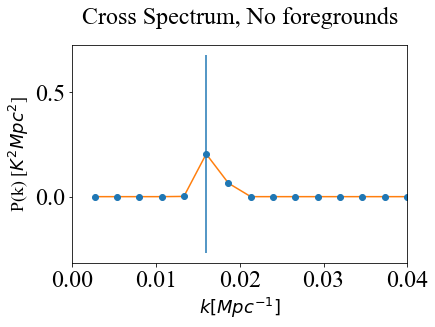

In [84]:

plt.errorbar(x = pk_hera[0],y = np.sum(pk_reals[0:9,:],axis = 0)/nreals, yerr = error_bars, xerr = None, fmt='o')
plt.title('Cross Spectrum, No foregrounds', y = 1.07, fontsize = 24)
plt.plot(pk_hera[0],np.sum(pk_reals[0:9,:],axis = 0)/nreals)
plt.xlabel('$k [Mpc^{-1}]$', fontsize = 18)
plt.ylabel('P(k) [$K^2 Mpc^{2}$]', fontsize = 18)
plt.xlim(0,0.04)

Text(0.5, 1.0, '50 Individual Realizations')

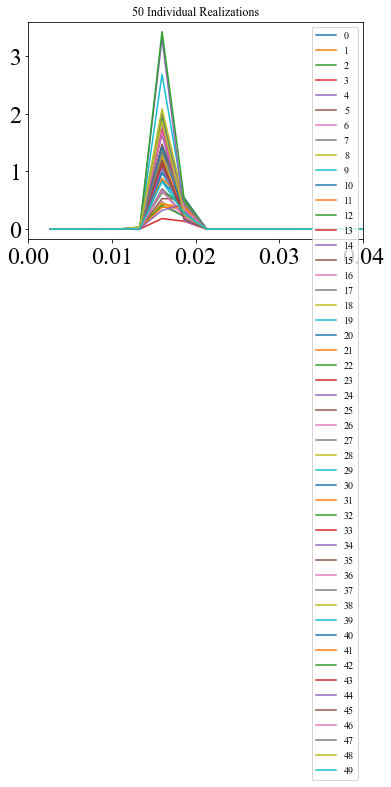

In [86]:
for i in range(nreals):
    
    plt.plot(k_cross,pk_reals[i,:], label = "%s"%i)
    plt.legend()

    plt.xlim(0,0.04)

plt.title('50 Individual Realizations')